In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
import string
import numpy as np
from sklearn.utils import shuffle
import collections
import re
import math
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\damio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
def tokenize(str_data):
    data = str_data.lower()
    data = re.sub(r'\n', '', data)
    data = re.sub(r'[^A-Za-z\s]', '', data)
    data = data.split(' ')
    data = list(filter(lambda item: item != '', data))
    return data
def extract_ngrams(tokens, n = 3):
    ngram_list = ngrams(tokens, n)
    return ngram_list

In [23]:
books = []

for i in range(1, 8):
    with open (f"harry_potter/HP{i}.txt", 'r') as f:
        pages = []
        data = f.read()
        data = data.split('\n')
        for page in data:
            pages.append(tokenize(page))
        books.append(pages)
        f.close()

In [24]:
data = []
labels = []
for i, book in enumerate(books):
    for page in book:
        data.append(page)
        labels.append(i + 1)
books = None

In [25]:
data, labels = shuffle(data, labels, random_state=0)
train_data = data[:int(len(data) * 0.8)]
train_labels = labels[:int(len(labels) * 0.8)]

test_data = data[int(len(data) * 0.8):int(len(data) * 0.9)]
test_labels = labels[int(len(labels) * 0.8):int(len(labels) * 0.9)]

val_data = data[int(len(data) * 0.9):]
val_labels = labels[int(len(labels) * 0.9):]

data = None
labels = None

In [26]:
word_frequencies = collections.defaultdict(lambda: collections.defaultdict(int))
for label, page in zip(train_labels, train_data):
    ngrams_list = list(extract_ngrams(page))
    for ngram in ngrams_list:
        word_frequencies[label][ngram] += 1

In [27]:
def classify(page, delta = 0.01):
    class_counts = collections.Counter(label for label in train_labels)
    class_priors = {cls: count / len(train_data) for cls, count in class_counts.items()}

    page_ngrams = list(extract_ngrams(page))

    probabilities = {}
    for label in class_counts.keys():
        prob = math.log(class_priors[label])

        for ngram in page_ngrams:
            n_count = word_frequencies[label][tuple(ngram)] + delta
            n_total = sum(word_frequencies[label].values()) + delta * len(word_frequencies[label])
            prob += math.log(n_count / n_total)
        probabilities[label] = prob

    return max(probabilities, key=probabilities.get)

### Testing different values of delta on valdiation set

In [28]:
deltas = [0.01, 0.001, 0.0001, 0.00005, 0.00001, 5e-6, 1e-6, 5e-7, 1e-7, 5e-8]
accuracies = []
print("Testing delta values : ", deltas)
best_delta = 0
best_accuracy = 0
for delta in deltas:
    predicted = []
    for page in val_data:
        predicted.append(classify(page, delta))
    cm = confusion_matrix(val_labels, predicted)
    tot = np.sum(cm)
    correct = np.sum(np.diagonal(cm))
    accuracy = correct/tot * 100
    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_delta = delta
    
    print(f"Accuracy for delta = {delta} is {accuracy}")

print(f"Best delta value is {best_delta} with accuracy {best_accuracy}")

Testing delta values :  [0.01, 0.001, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06, 5e-07, 1e-07, 5e-08]
Accuracy for delta = 0.01 is 20.8067940552017
Accuracy for delta = 0.001 is 38.6411889596603
Accuracy for delta = 0.0001 is 59.23566878980891
Accuracy for delta = 5e-05 is 61.78343949044586
Accuracy for delta = 1e-05 is 63.69426751592356
Accuracy for delta = 5e-06 is 63.90658174097664
Accuracy for delta = 1e-06 is 63.69426751592356
Accuracy for delta = 5e-07 is 64.3312101910828
Accuracy for delta = 1e-07 is 62.84501061571125
Accuracy for delta = 5e-08 is 61.3588110403397
Best delta value is 5e-07 with accuracy 64.3312101910828


### Evaluating final accuracy on testing set

In [29]:
#From above we see that delta = 0.003 yields best accuracy 
#Use this delta on the testing set now 
predicted = []
for page in test_data:
    predicted.append(classify(page, best_delta))

In [30]:
cm = confusion_matrix(test_labels, predicted)
print("Confusion Matrix for testing set : ")
print(cm)
print()
print("Classification Report : ")
report = classification_report(test_labels, predicted, target_names=['HP1', 'HP2', 'HP3', 'HP4', 'HP5', 'HP6', 'HP7'])
print(report)

Confusion Matrix for testing set : 
[[19  1  2  2  3  1  2]
 [ 2 18  1  5  8  2  0]
 [ 2  3 20  6  7  3  0]
 [ 1  2  1 57 10  1  1]
 [ 1  4  6  8 80 10  3]
 [ 1  1  3  6 16 48  7]
 [ 2  2  3  3 15  8 64]]

Classification Report : 
              precision    recall  f1-score   support

         HP1       0.68      0.63      0.66        30
         HP2       0.58      0.50      0.54        36
         HP3       0.56      0.49      0.52        41
         HP4       0.66      0.78      0.71        73
         HP5       0.58      0.71      0.64       112
         HP6       0.66      0.59      0.62        82
         HP7       0.83      0.66      0.74        97

    accuracy                           0.65       471
   macro avg       0.65      0.62      0.63       471
weighted avg       0.66      0.65      0.65       471



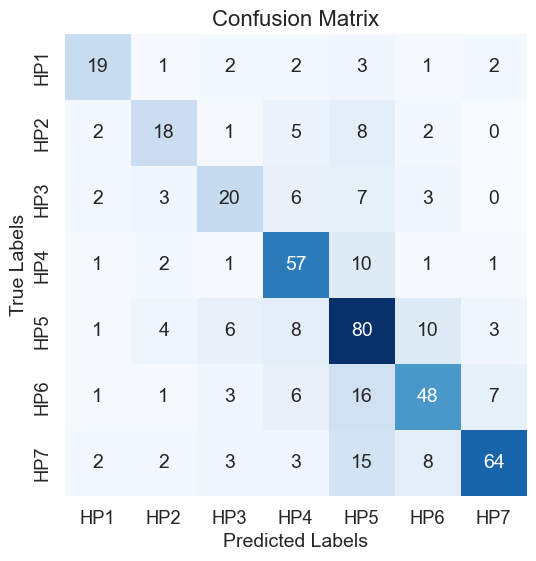

In [31]:
# Create a heatmap using seaborn
class_labels = ['HP1', 'HP2', 'HP3', 'HP4', 'HP5', 'HP6', 'HP7']
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14}, square=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.savefig('confusion_matrix.png', dpi=300)

<Figure size 1000x600 with 0 Axes>

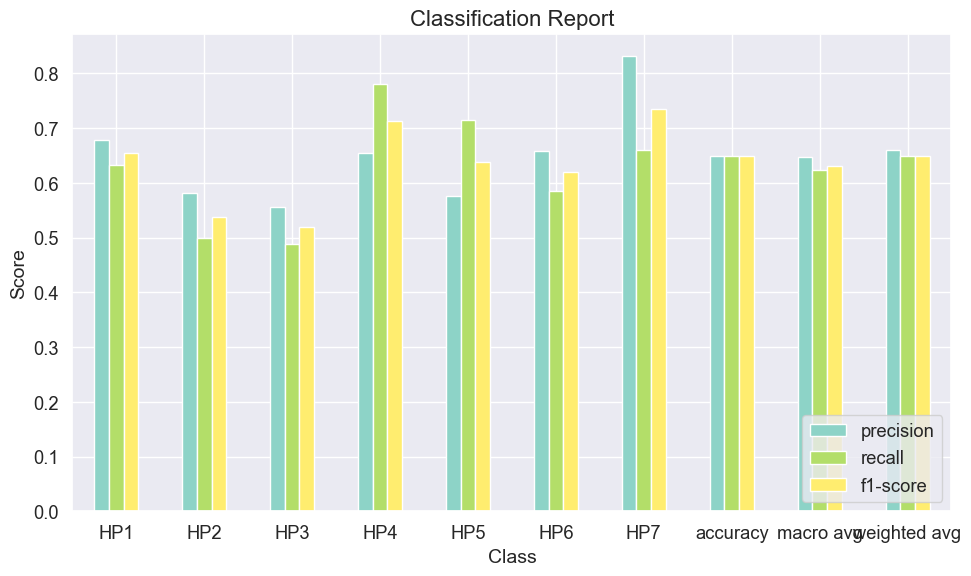

In [33]:
# Convert the classification report to a pandas DataFrame for easier manipulation
report = classification_report(test_labels, predicted, target_names=['HP1', 'HP2', 'HP3', 'HP4', 'HP5', 'HP6', 'HP7'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and F1-score using a bar chart
plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', colormap='Set3', figsize=(10, 6))
plt.xticks(rotation=0)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Classification Report', fontsize=16)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('classification_report.png', dpi=300)

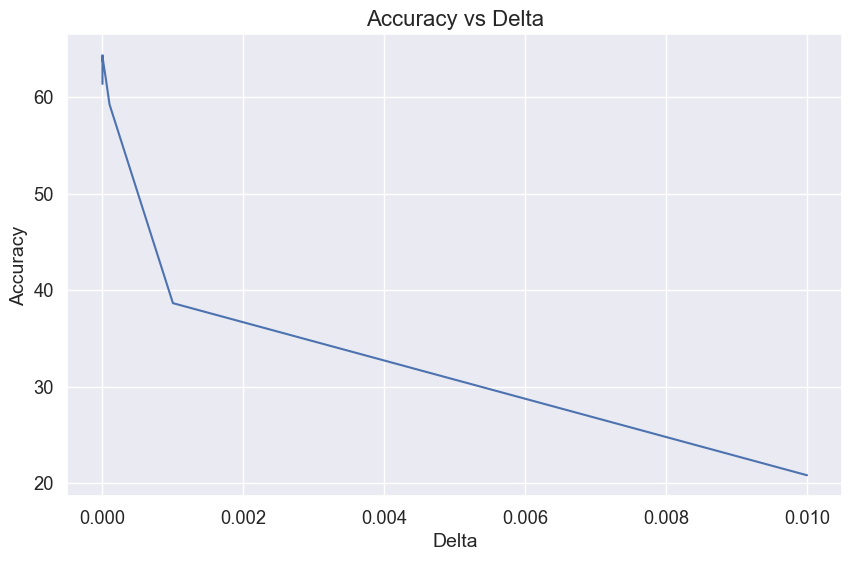

In [34]:
#Plot the accuracy against deltas
plt.figure(figsize=(10, 6))
plt.plot(deltas, accuracies)
plt.xlabel('Delta', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Delta', fontsize=16)
plt.savefig('accuracy_vs_delta.png', dpi=300)

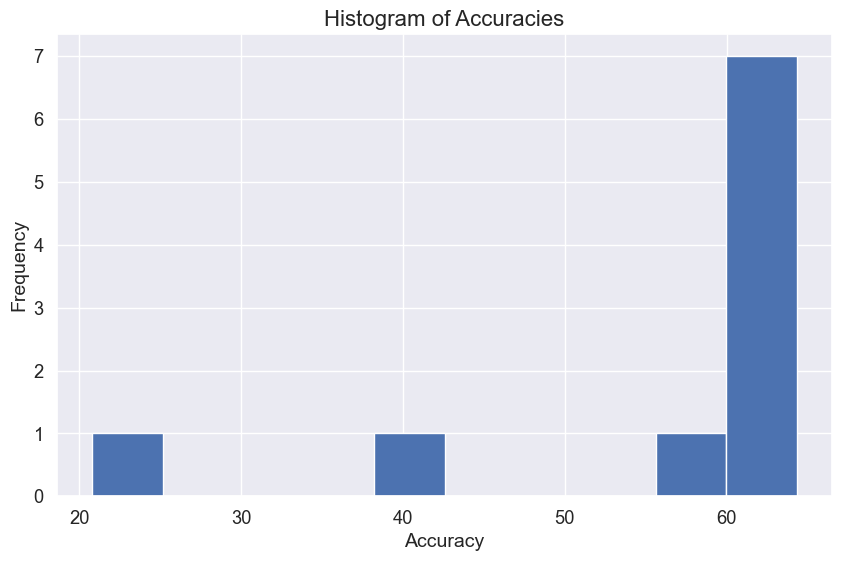

In [35]:
# Plot histogram of accuracies against deltas
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=10)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Accuracies', fontsize=16)
plt.savefig('histogram_of_accuracies.png', dpi=300)
